**A data science experiment using data from the KDD 2010 Educational Data Mining Challenge**

The aim of this IPython Notebook is to give you a sense of the dataset.


In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import random
import string

In [229]:
# Get the data:
test_filepath = 'test.csv'
testdata = pd.read_table(test_filepath)
train_filepath = 'train.csv'
traindata = pd.read_table(train_filepath)

In [3]:
traindata.columns

Index(['Row', 'Anon Student Id', 'Problem Hierarchy', 'Problem Name',
       'Problem View', 'Step Name', 'Step Start Time',
       'First Transaction Time', 'Correct Transaction Time', 'Step End Time',
       'Step Duration (sec)', 'Correct Step Duration (sec)',
       'Error Step Duration (sec)', 'Correct First Attempt', 'Incorrects',
       'Hints', 'Corrects', 'KC(Default)', 'Opportunity(Default)'],
      dtype='object')

In [257]:
# Inspect some of the training data
testdata.head()

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,10039,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP01,1,2/300*X = 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10482,52vEY7f17k,"Unit CTA1_06, Section CTA1_06-3",FOR05,1,xScale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Changing axis intervals,28
2,11024,52vEY7f17k,"Unit ES_03, Section ES_03-6",EG52,1,2.9 = -2x+3.7+x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[SkillRule: Consolidate vars, no coeff; CLT]",27
3,11476,52vEY7f17k,"Unit CTA1_08, Section CTA1_08-3",REAL10,1,yScale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Changing axis intervals,65
4,11948,52vEY7f17k,"Unit ES_04, Section ES_04-12",EG58,7,xR2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
traindata['Step Name']

0         R1C1
1         R1C2
2         R3C1
3         R3C2
4         R4C1
          ... 
232739    R5C1
232740    R1C2
232741    R2C2
232742    R3C2
232743    R6C2
Name: Step Name, Length: 232744, dtype: object

Let's begin asking some basic questions of the data

### How many students are interacting with the system?

In [6]:
# Take the column of anonimized student IDs and count the number of unique entries
print('Number of students: ', len(np.unique(traindata['Anon Student Id'])))

Number of students:  174


### How long does it take a student to solve any problem step on average?

In [111]:
csd = traindata['Correct Step Duration (sec)']
csd.describe()

count    181599.000000
mean         17.924024
std          35.179534
min           0.000000
25%           5.000000
50%           8.000000
75%          17.000000
max        1067.000000
Name: Correct Step Duration (sec), dtype: float64

So ignoring all the students that did not solve a problem step correctly, the average duraction for any problem step was about 18 seconds.

Let's histogram this data to see the distribution.

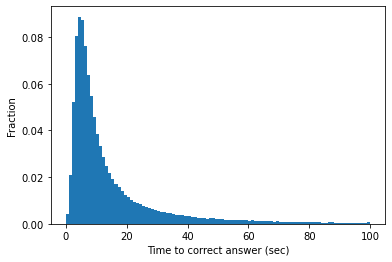

In [8]:
%matplotlib inline
hist = plt.hist(np.array(csd.dropna()),bins=100,density=True,log=False,range=(0,100))
plt.xlabel('Time to correct answer (sec)')
plt.ylabel('Fraction')
plt.show()

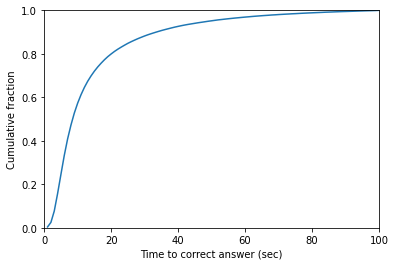

In [9]:
counts, bins = hist[0], hist[1]
cdf = np.cumsum(counts)
plt.plot(bins[1::], cdf)
plt.xlabel('Time to correct answer (sec)')
plt.ylabel('Cumulative fraction')
plt.axis((0,100,0,1.0))
plt.show()

The histogram shows visually what mere statistics hints at. The distribution of students is heavily weighted towards those who are solving problems in under 20 seconds. The cumulative distribution function (CDF) shows that roughly 80% of successful students solve the problem within 20 seconds. After 40 seconds, 90% of successful students have finished the problem. Almost no students take longer than 80 seconds.

### Completion time by problem

OK, let's ask a slightly harder question: how are students doing problem by problem? The answer will take several parts.

First, let's get the number of unique problems

In [10]:
# The unique identifier for each problem is the 'Problem Name'
problems = traindata['Problem Name']

In [112]:
# Get just the uniques
problems = np.unique(problems)
print('Number of unique problems: ', len(problems))

Number of unique problems:  1021
1PTB02
1PTB03
1PTB04
1PTB05
1PTB06
1PTB07
1PTB08
1PTB09
1PTFB10
1PTFB11


Then, let's compute which problems need the largest time on average.

In [113]:
pmedian_times = {}
for p in problems:
    pmedian_times[p] = traindata[traindata['Problem Name'] == p]['Correct Step Duration (sec)'].median()

In [13]:
import operator

In [14]:
sorted_times = sorted(pmedian_times.items(), key=operator.itemgetter(1), reverse=True)

In [15]:
print("The hardest top-5 problem and its average correct duration (sec).")
print(sorted_times[:5])

print("The earliest top-5 problem and its average correct duration (sec).")
print(sorted_times[len(sorted_times)-5:])

The hardest top-5 problem and its average correct duration (sec).
[('JAN13C', 65.0), ('TRANSFORMN022', 32.0), ('EG-FACTOR45', 30.0), ('BH1T33B', 25.0), ('EG-FACTOR47', 23.0)]
The earliest top-5 problem and its average correct duration (sec).
[('TRANSFORMN013', 1.25), ('TRANSFORMN014', 1.25), ('TRANSFORMG042', 1.0), ('TRANSFORMN004', 1.0), ('TRANSFORMN005', 1.0)]


Statistical results of problem difficulty

D:\anaconda\setanaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\anaconda\setanaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


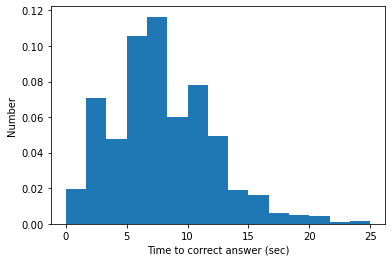

In [110]:
hist = plt.hist(np.array(list(pmedian_times.values())),bins=15,density=True,log=False,range=(0,25))
plt.xlabel('Time to correct answer (sec)')
plt.ylabel('Number')
plt.show()

If we take the time to correct answer as the difficulty of a problem, the histogram shows visually the difficulties of all the problems. 

### Conclusion
There are many other interesting characteristic in this dataset.
Like, 
* After some practices, students may become better at solving problems.
* Same problem step for different students may request different knowledge components. Or for some problems, there is only one correct knowledge components

These may be some things you need to take consider into for the feature engineering part. We leave them for you to explore deeper.

In [297]:
test2_filepath = 'test2.csv'
test2data=pd.read_table(test_filepath)


test2data['Correct First Attempt'] = dfct['Correct First Attempt'].apply(lambda x: KC(x)) 
test2data.to_csv('test3.csv',index=False)
test2data.head()


,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,10039,52vEY7f17k,"Unit CTA1_13, Section CTA1_13-1",PROP01,1,2/300*X = 10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
1,10482,52vEY7f17k,"Unit CTA1_06, Section CTA1_06-3",FOR05,1,xScale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,Changing axis intervals,28
2,11024,52vEY7f17k,"Unit ES_03, Section ES_03-6",EG52,1,2.9 = -2x+3.7+x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,"[SkillRule: Consolidate vars, no coeff; CLT]",27
3,11476,52vEY7f17k,"Unit CTA1_08, Section CTA1_08-3",REAL10,1,yScale,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,Changing axis intervals,65
4,11948,52vEY7f17k,"Unit ES_04, Section ES_04-12",EG58,7,xR2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN
